In [273]:
import numpy as np
import pandas as pd

In [274]:
data = pd.read_csv("../datasets/cbecs2018_final_public.csv")

In [275]:
data.shape

(6436, 1249)

In [276]:
data.head()

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
0,1,3,5,2,3,210000,8,1,4,2,...,0,0,0,0,9,9,1,1,0,0
1,2,4,9,2,4,28000,5,1,6,1,...,0,0,0,0,0,0,9,9,9,9
2,3,3,5,8,4,2100,2,1,4,2,...,0,0,0,0,9,9,9,9,9,9
3,4,3,7,5,5,240000,8,2,6,1,...,0,0,0,0,1,1,9,9,9,9
4,5,1,2,5,3,295000,8,3,6,2,...,0,0,0,0,0,0,9,9,9,9


In [277]:
data.columns

Index(['PUBID', 'REGION', 'CENDIV', 'PBA', 'PUBCLIM', 'SQFT', 'SQFTC', 'WLCNS',
       'RFCNS', 'RFCOOL',
       ...
       'ZMFBTU', 'ZMFEXP', 'ZELCNS', 'ZELEXP', 'ZNGCNS', 'ZNGEXP', 'ZFKCNS',
       'ZFKEXP', 'ZDHBTU', 'ZDHEXP'],
      dtype='object', length=1249)

In [278]:
data.describe()

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
count,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6.436000e+03,6436.000000,6436.000000,6436.000000,6436.000000,...,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000
mean,3218.500000,2.629739,5.105811,12.564947,3.646830,1.691617e+05,5.611871,2.379273,4.355811,1.501554,...,0.429459,0.449658,0.407085,0.441112,2.871193,2.909571,6.785270,6.804848,8.273928,8.275637
std,1858.057498,1.006943,2.439221,11.937664,1.701329,2.851251e+05,2.304431,1.741901,2.081375,0.500036,...,1.092531,1.093648,1.090856,1.093221,3.978072,3.954940,3.681433,3.647798,2.358672,2.353031
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.001000e+03,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1609.750000,2.000000,3.000000,5.000000,2.000000,1.125000e+04,4.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,9.000000,9.000000
50%,3218.500000,3.000000,5.000000,13.000000,3.000000,6.900000e+04,6.000000,1.000000,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,9.000000,9.000000,9.000000
75%,4827.250000,3.000000,7.000000,16.000000,5.000000,2.100000e+05,8.000000,3.000000,6.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
max,6436.000000,4.000000,9.000000,91.000000,7.000000,2.100000e+06,10.000000,8.000000,8.000000,2.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [279]:
columns = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN", "PVC", \
           "PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "DCNTRSFC", "ELEXP"]

In [280]:
df = data[columns]

In [281]:
df.head()

,DATACNTR,TRNGRM,STDNRM,LGOFFDEV,SMOFFDEV,SERVER,LAPTOP,RFGSTO,ELCOOL,GOVOWN,...,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP,DCNTRSFC,ELEXP
0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1,1,...,250.0,50.0,NaN,100.0,70.0,NaN,4.0,100.0,4.0,775800.0
1,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1,2,...,20.0,5.0,100.0,1.0,2.0,10.0,NaN,100.0,NaN,77933.0
2,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1,2,...,2.0,5.0,2.0,1.0,NaN,3.0,NaN,100.0,NaN,3472.0
3,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1,2,...,15.0,10.0,NaN,1.0,NaN,9.0,NaN,45.0,NaN,41197.0
4,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2,2,...,10.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,33688.0


In [282]:
df.describe()

,DATACNTR,TRNGRM,STDNRM,LGOFFDEV,SMOFFDEV,SERVER,LAPTOP,RFGSTO,ELCOOL,GOVOWN,...,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP,DCNTRSFC,ELEXP
count,5793.000000,5793.000000,5793.000000,6314.000000,6314.000000,6314.000000,6314.000000,5416.000000,6436.000000,6436.000000,...,5540.000000,4758.000000,3475.000000,3633.000000,3814.000000,5073.000000,1301.000000,5980.000000,897.000000,6.357000e+03
mean,1.845158,1.776627,1.831348,1.395946,1.196547,1.424612,1.246436,1.957164,1.114201,1.745960,...,173.868773,145.064523,101.355108,84.003303,72.832197,194.022078,118.190623,81.194314,2.147157,2.535272e+05
std,0.361785,0.416542,0.374476,0.489092,0.397419,0.494323,0.430970,0.202506,0.318080,0.435354,...,443.911787,308.190016,235.954625,826.355795,739.630732,1250.707378,953.921298,29.075135,1.277630,5.776407e+05
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.200000e+01
25%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,6.000000,5.000000,5.000000,2.000000,2.000000,4.000000,4.000000,75.000000,1.000000,1.180600e+04
50%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,...,30.000000,23.000000,20.000000,4.000000,5.000000,10.000000,12.000000,100.000000,2.000000,6.674000e+04
75%,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,...,150.000000,100.000000,99.500000,10.000000,15.000000,30.000000,40.000000,100.000000,3.000000,2.555860e+05
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3615.000000,1480.000000,1410.000000,9995.000000,9995.000000,9995.000000,9995.000000,100.000000,5.000000,1.487568e+07


In [283]:
missing_values = df.isnull().sum()
print(missing_values)


DATACNTR      643
TRNGRM        643
STDNRM        643
LGOFFDEV      122
SMOFFDEV      122
SERVER        122
LAPTOP        122
RFGSTO       1020
ELCOOL          0
GOVOWN          0
PVC          4137
PCTERMN       896
LAPTPN       1678
TABLETN      2961
SERVERN      2803
LGOFFDEVN    2622
SMOFFDEVN    1363
WBOARDSN     5135
COOLP         456
DCNTRSFC     5539
ELEXP          79
dtype: int64


In [284]:
df = df.dropna(subset=['ELEXP'])
df.shape

(6357, 21)

In [285]:
cat_cols = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN", "PVC", "DCNTRSFC" ]
cont_cols = ["PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "ELEXP"]

In [286]:
unique_counts = df[cat_cols+cont_cols].nunique()
print(unique_counts)

DATACNTR        2
TRNGRM          2
STDNRM          2
LGOFFDEV        2
SMOFFDEV        2
SERVER          2
LAPTOP          2
RFGSTO          2
ELCOOL          2
GOVOWN          2
PVC             2
DCNTRSFC        5
PCTERMN       256
LAPTPN        176
TABLETN       113
SERVERN        76
LGOFFDEVN      72
SMOFFDEVN      98
WBOARDSN       78
COOLP          86
ELEXP        6232
dtype: int64


### Numerical Columns EDA

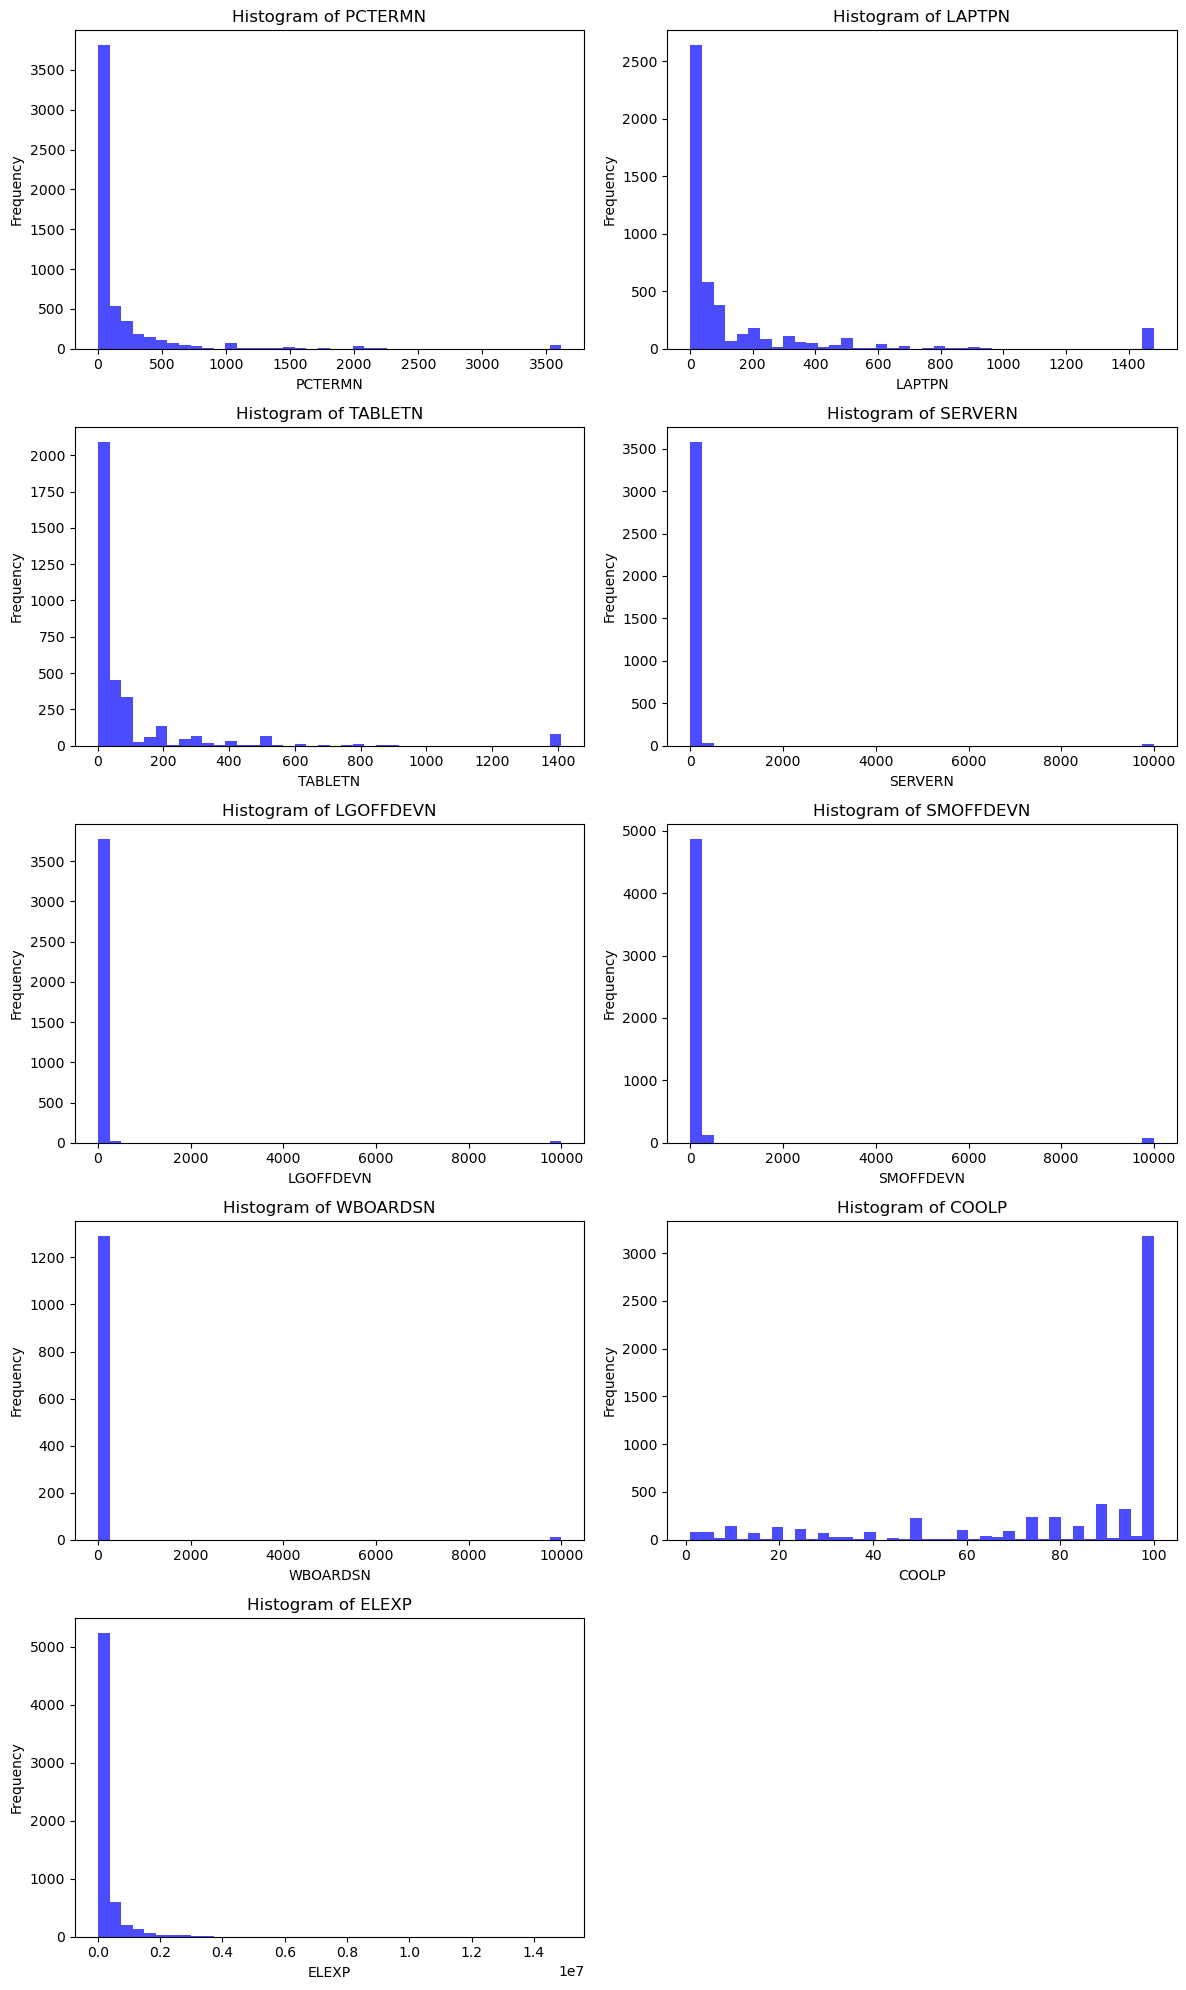

In [287]:
import matplotlib.pyplot as plt


num_cols = len(cont_cols)

# Create subplots
rows = (num_cols + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot histograms
for i, col in enumerate(cont_cols):
    axes[i].hist(df[col].dropna(), bins=40, alpha=0.7, color='blue')  # Exclude NA values
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

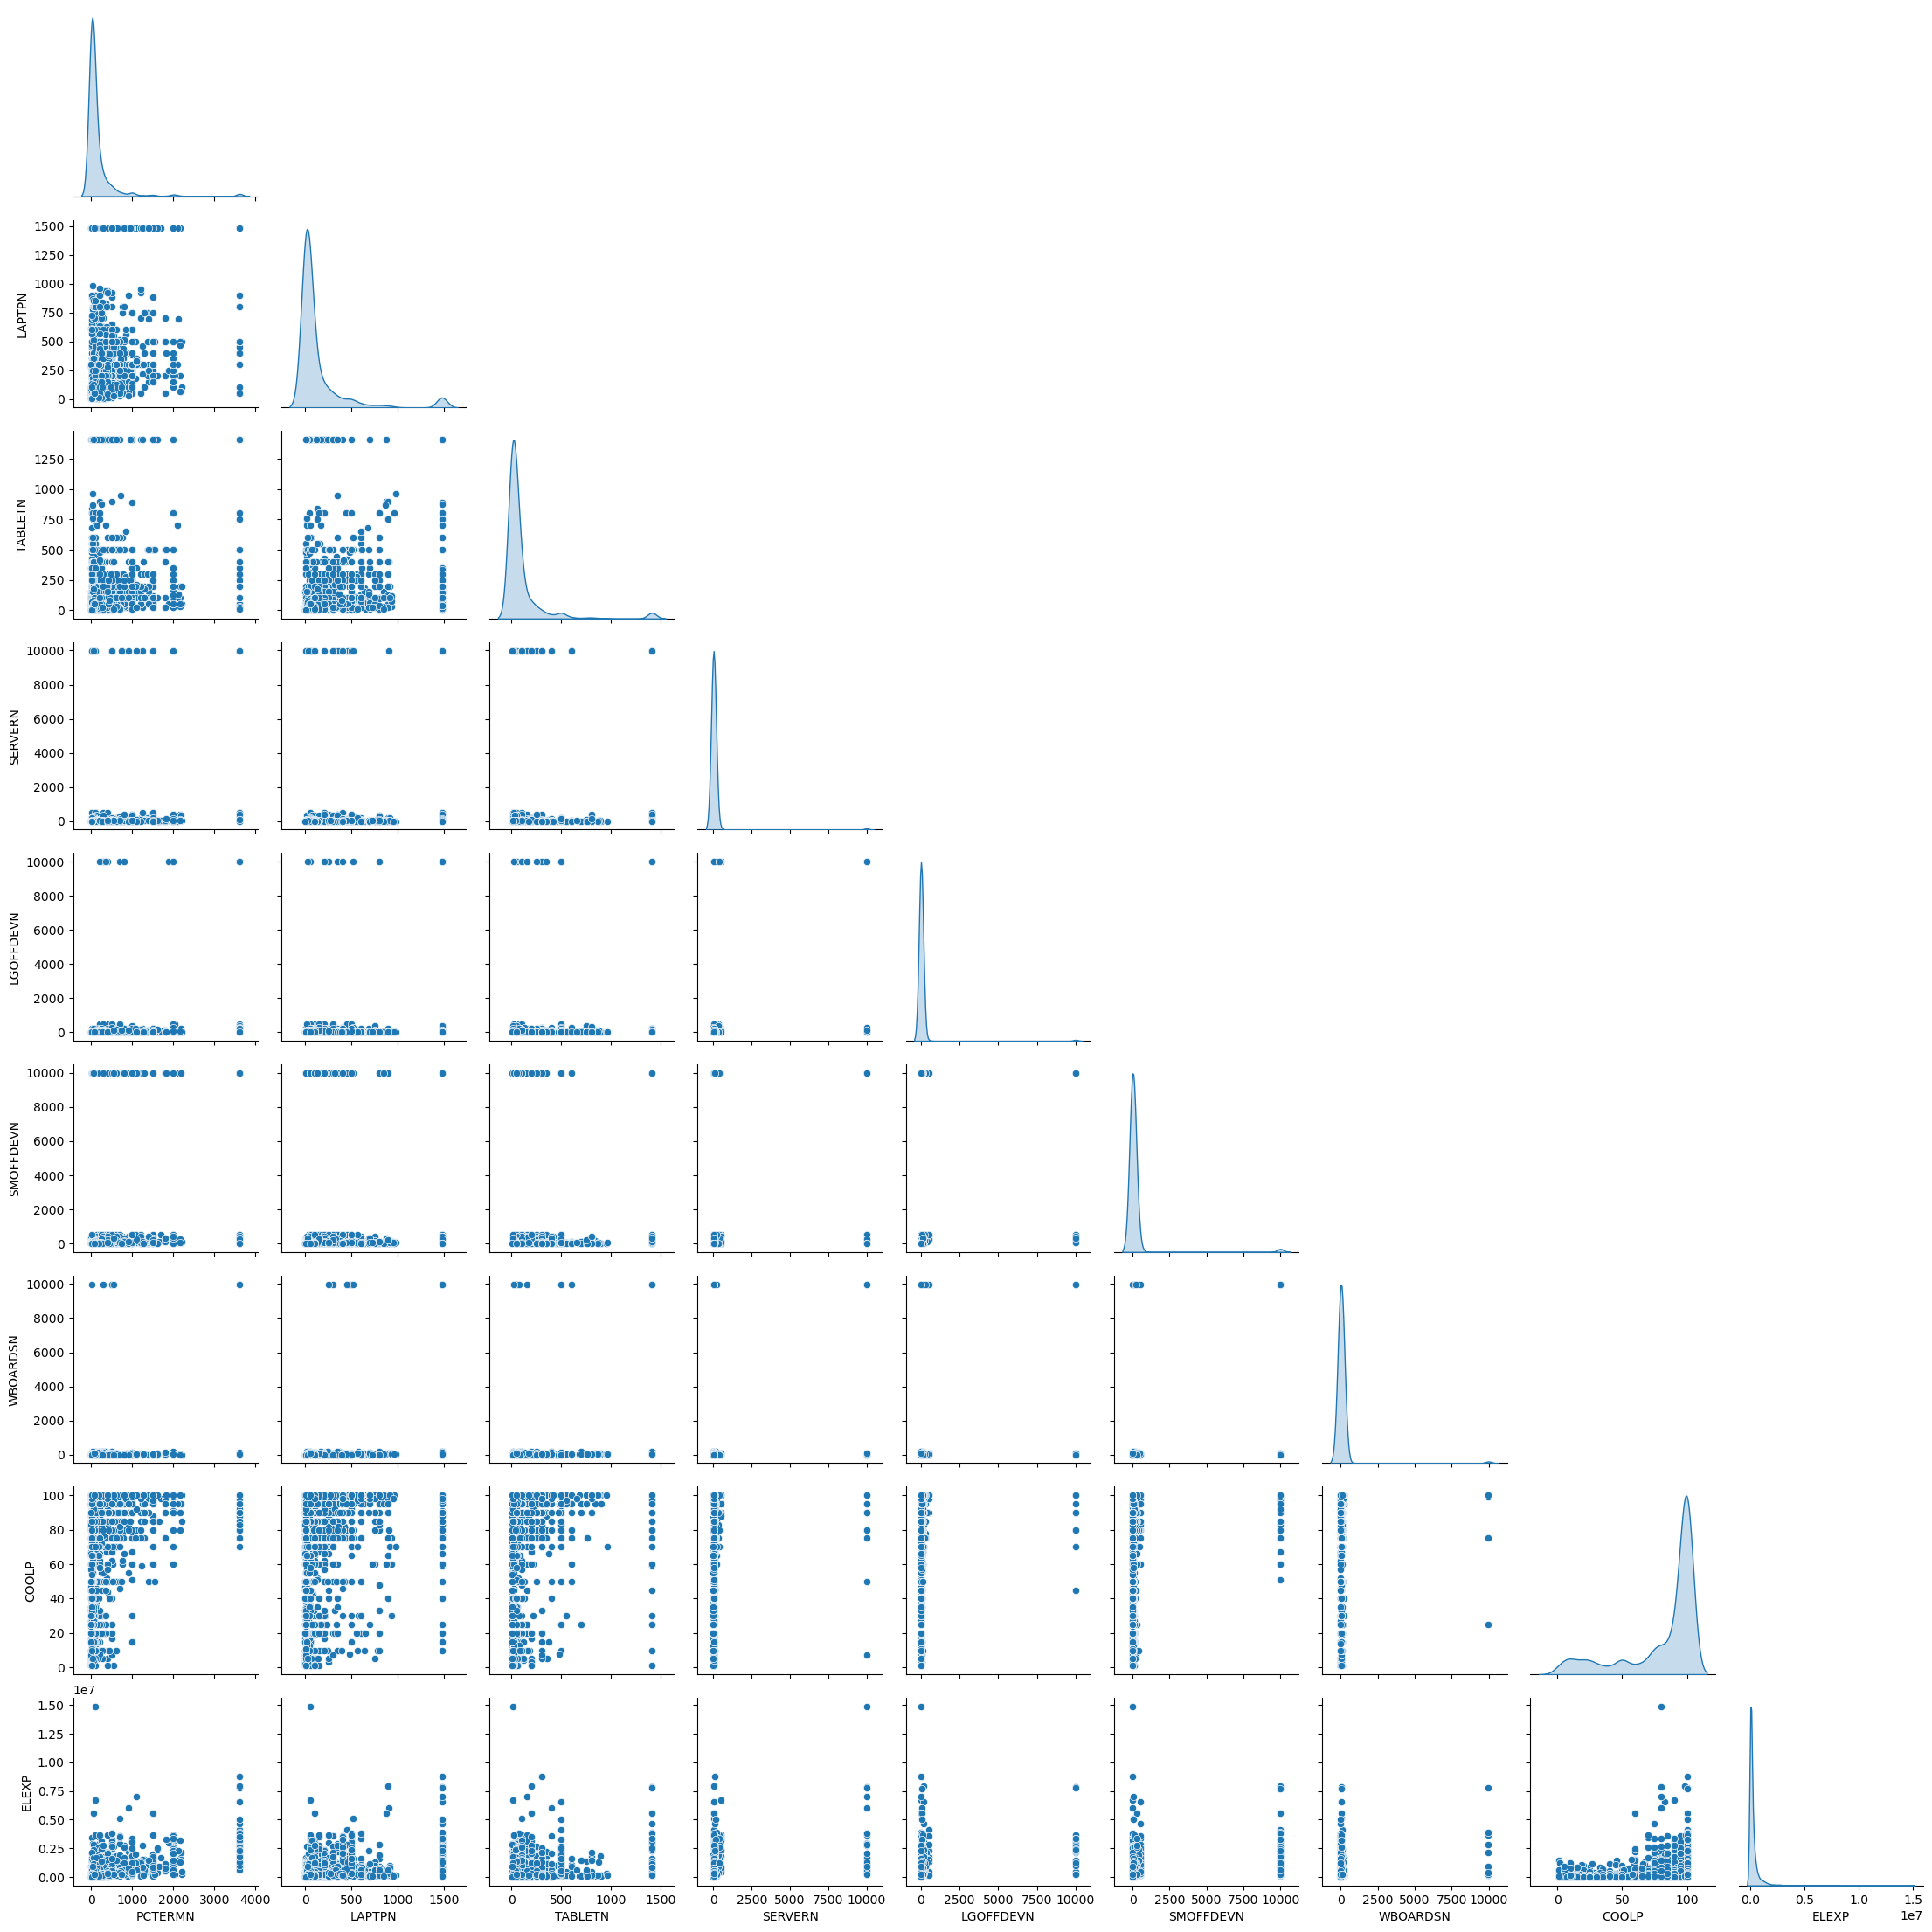

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot
sns.pairplot(df[cont_cols], diag_kind='kde', corner=True)  # 'diag_kind' for diagonal plots; 'corner=True' for a lower triangle plot
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


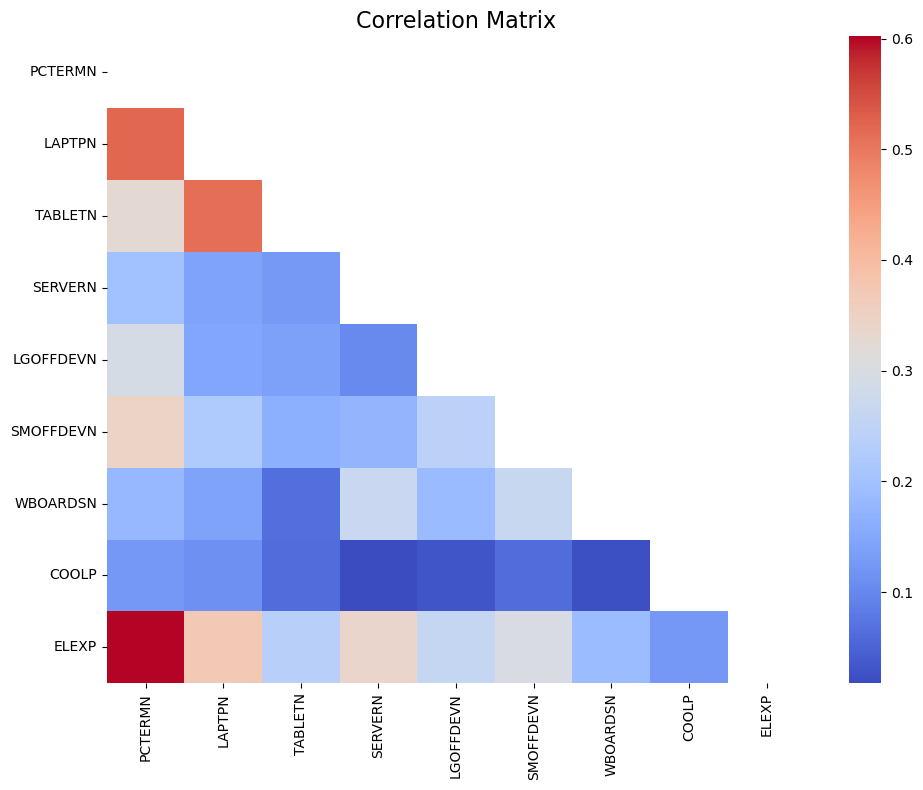

In [289]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Compute the correlation matrix for numerical columns
correlation_matrix = df[cont_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()


### Categorical EDA

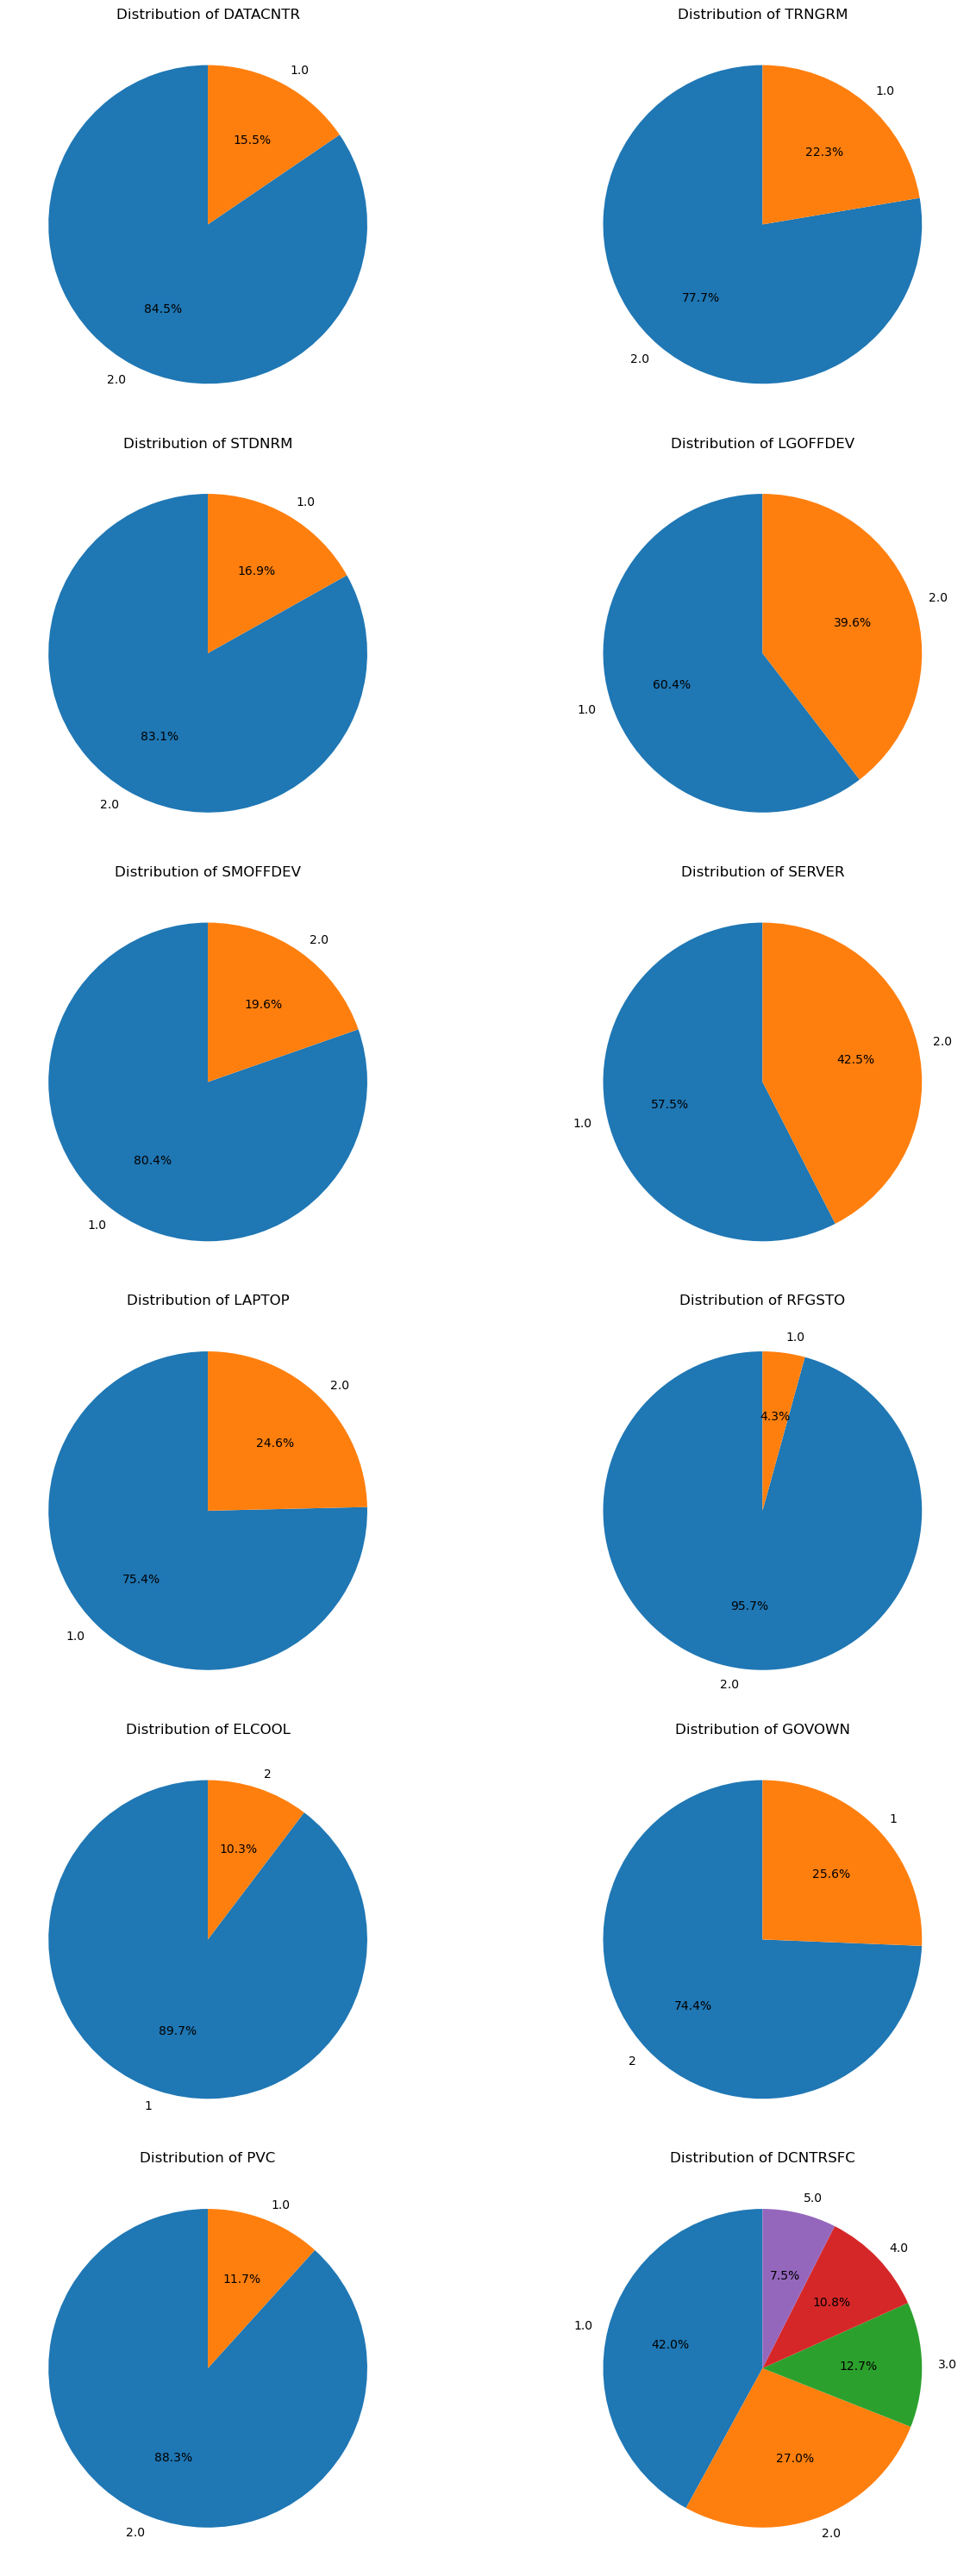

In [290]:
import matplotlib.pyplot as plt



# Determine the number of rows and columns for subplots
n_cols = 2  # Number of pie charts per row
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Calculate the number of rows

# Create a subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each categorical column and plot the pie chart
for i, col in enumerate(cat_cols):
    value_counts = df[col].value_counts(normalize=True) * 100  # Percentage of unique values
    labels = value_counts.index  # Categories as labels
    sizes = value_counts.values  # Percentages as sizes

    axes[i].pie(sizes, labels=labels, autopct="%.1f%%", startangle=90)
    axes[i].set_title(f"Distribution of {col}")

# Remove any extra subplots (if cat_cols < total grid slots)
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


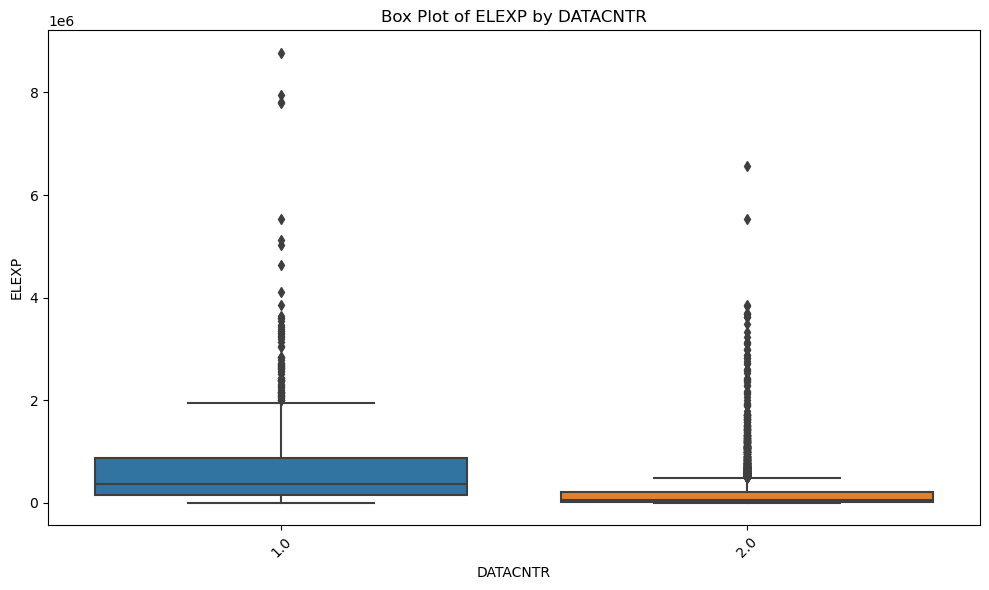

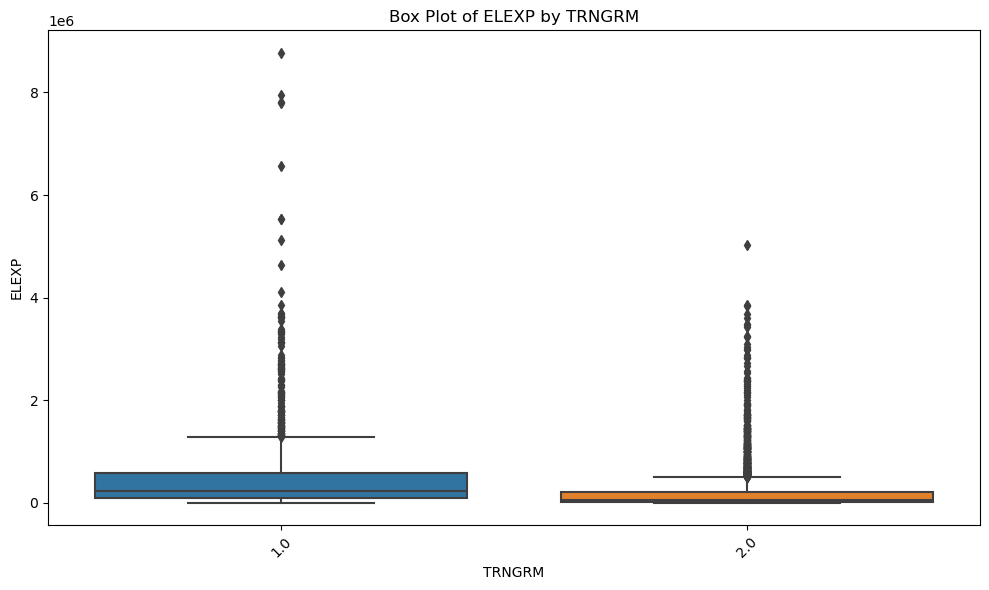

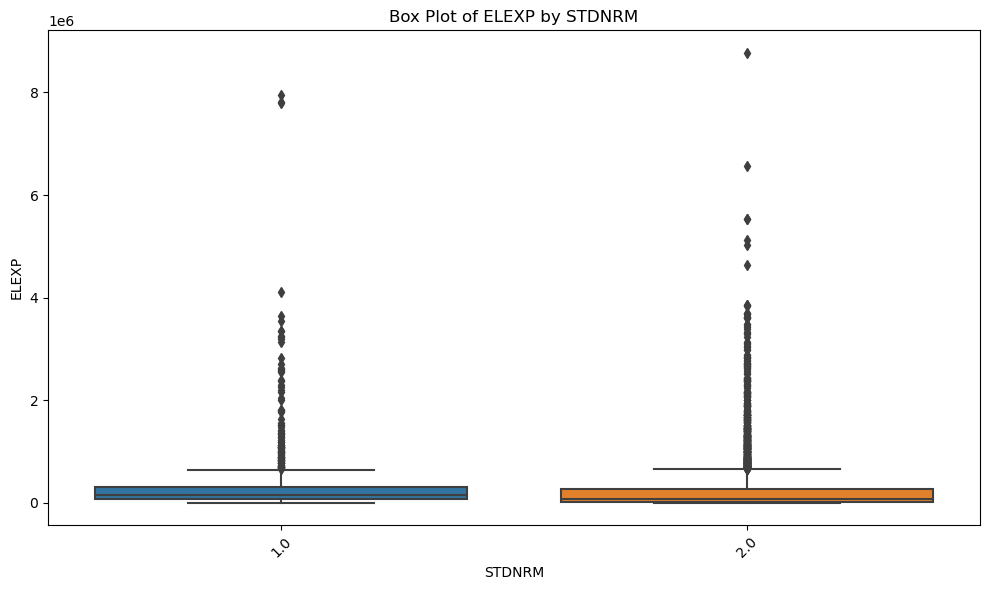

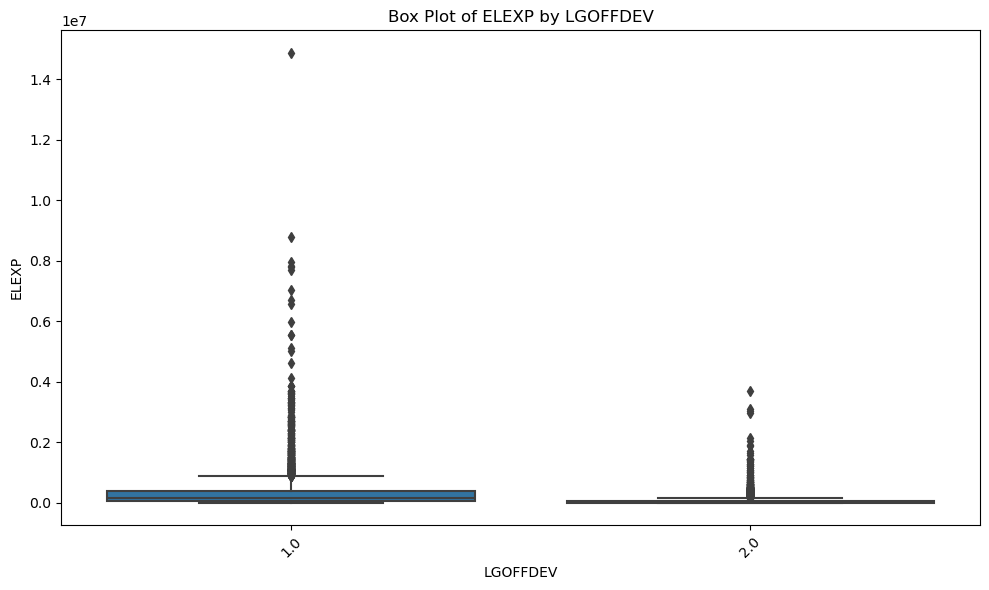

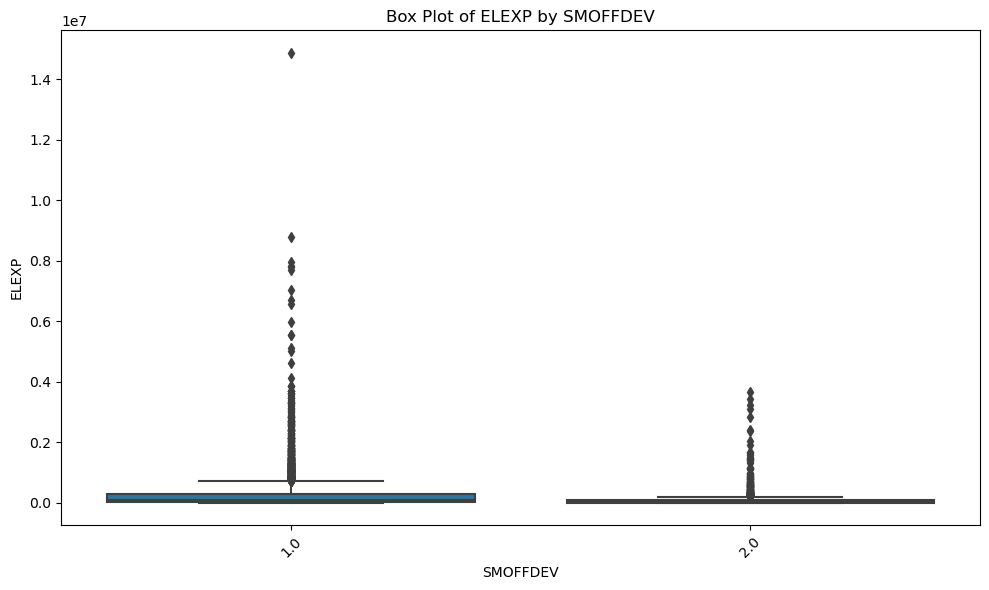

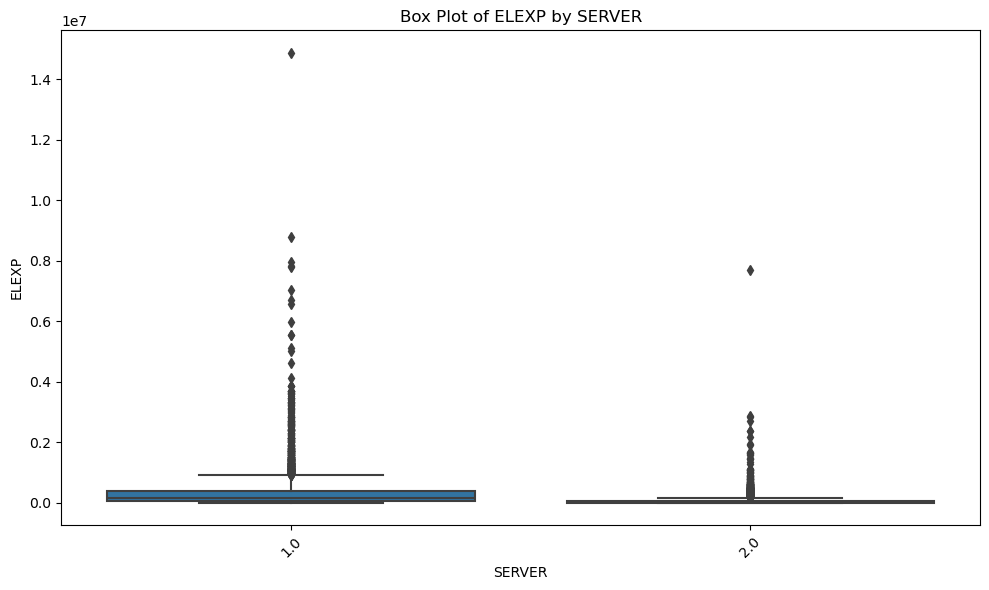

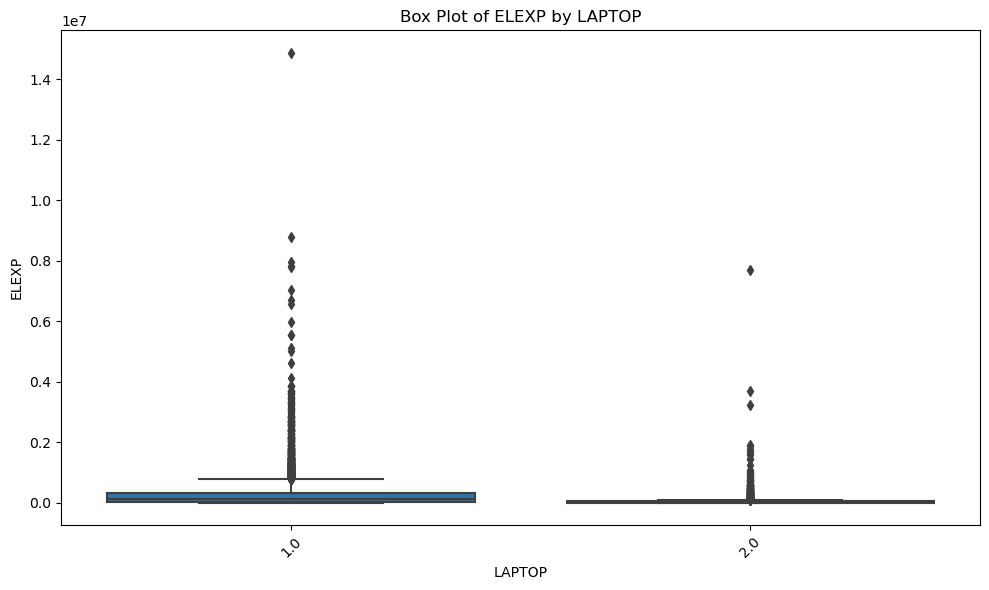

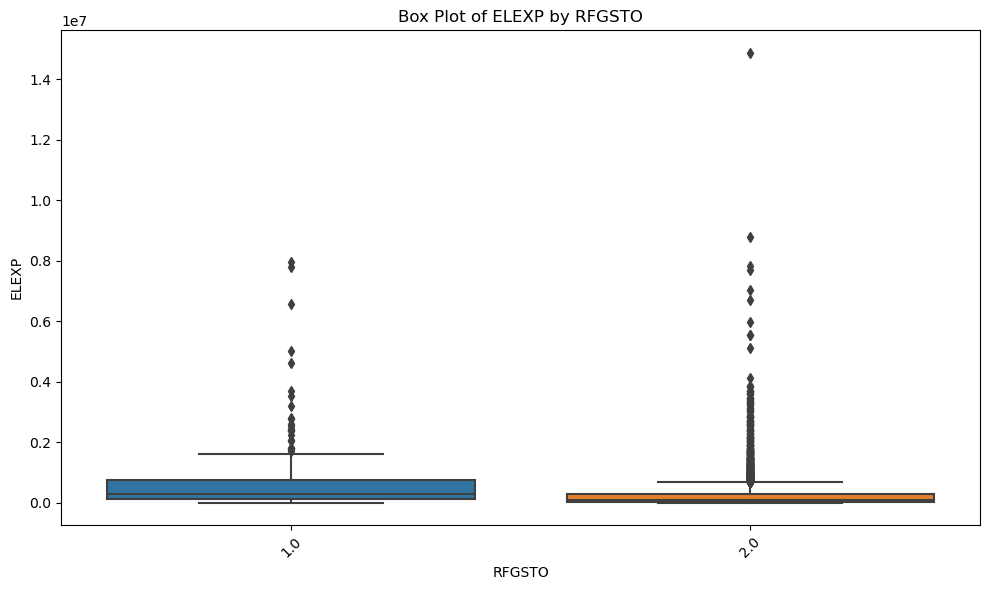

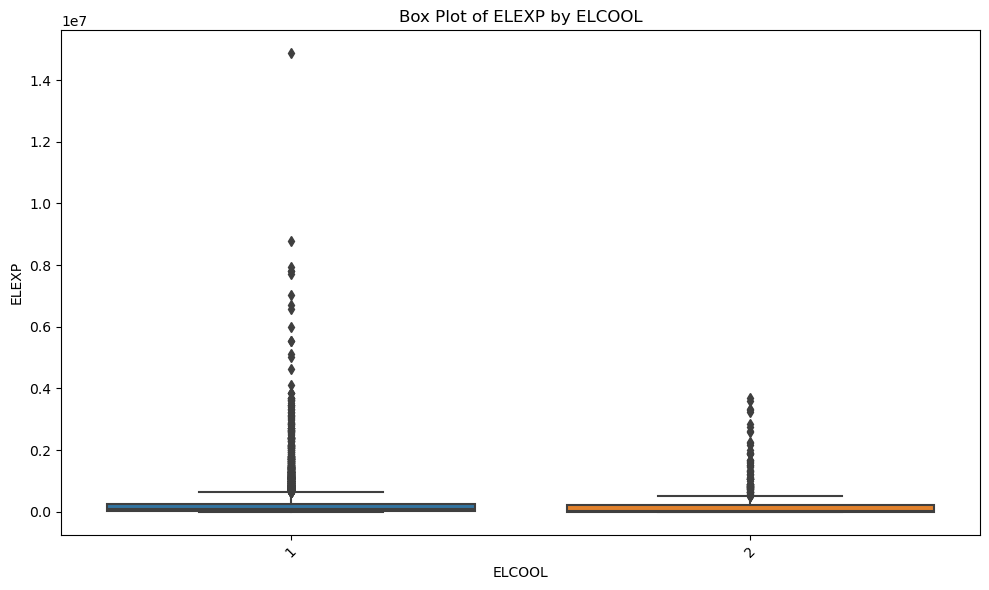

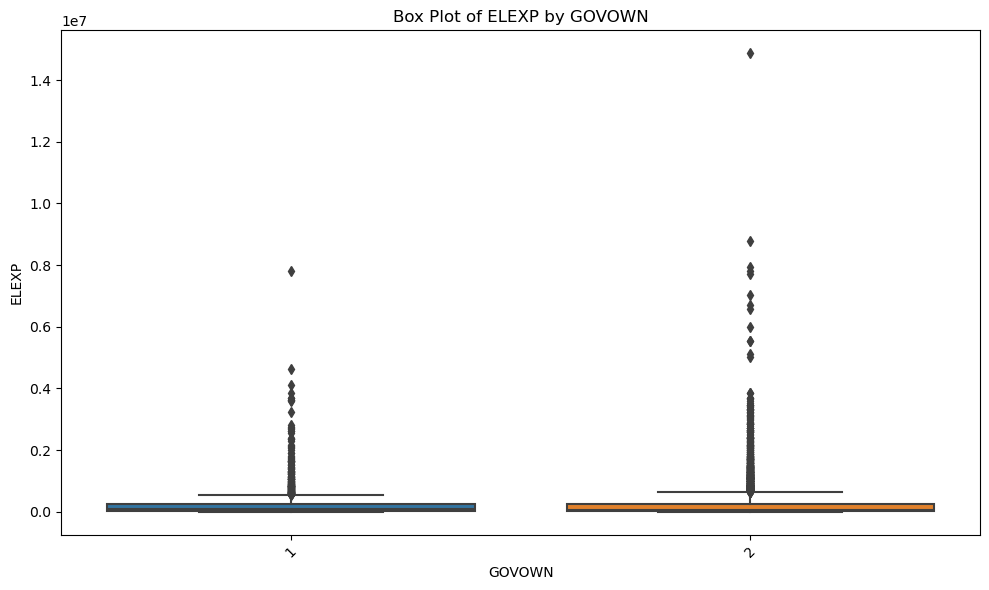

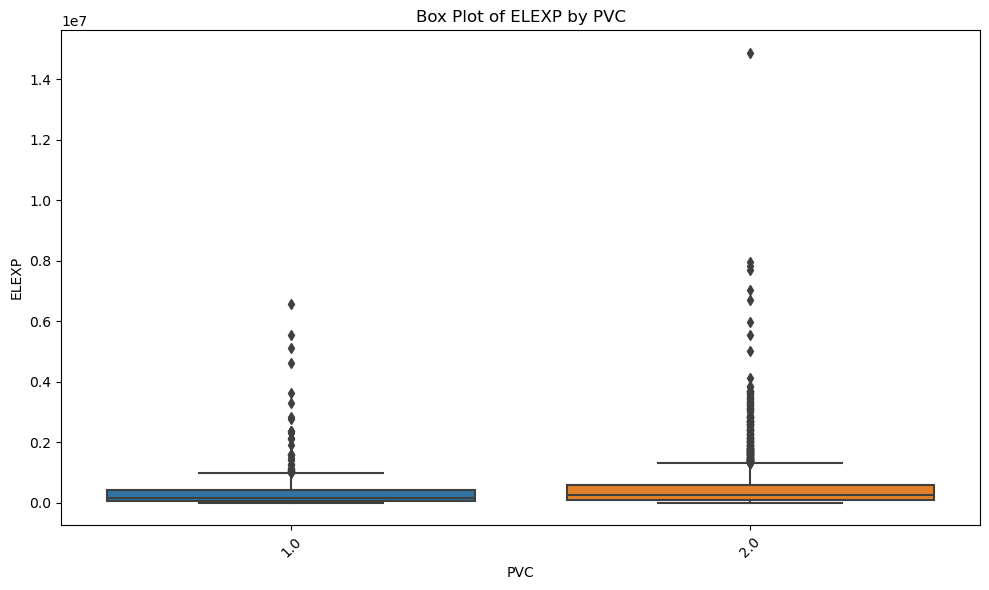

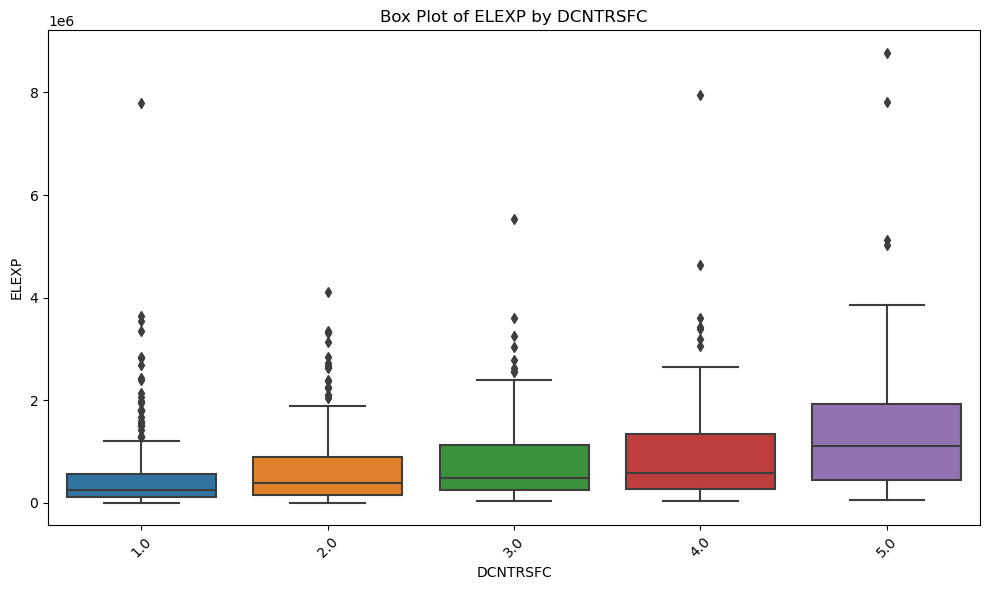

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume `cat_cols` contains the list of categorical columns
# Assume `num_col` is the numerical column for box plots
num_col = 'ELEXP'       # Replace with your actual numerical column

# Iterate through each categorical column
for cat_col in cat_cols:
    plt.figure(figsize=(10, 6))  # Set figure size
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.title(f"Box Plot of {num_col} by {cat_col}")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()


In [292]:
from scipy.stats import f_oneway

target_col = "ELEXP"
for cat_col in cat_cols:
    df1 = df.dropna(subset=[cat_col, target_col])
    # Group numerical target by each category in the categorical column
    groups = [df1[target_col][df1[cat_col] == category] for category in df1[cat_col].unique()]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Display Results
    print(f"ANOVA results for {cat_col}:")
    print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 40)


ANOVA results for DATACNTR:
F-statistic: 776.3477, P-value: 0.0000
----------------------------------------
ANOVA results for TRNGRM:
F-statistic: 409.7428, P-value: 0.0000
----------------------------------------
ANOVA results for STDNRM:
F-statistic: 13.2202, P-value: 0.0003
----------------------------------------
ANOVA results for LGOFFDEV:
F-statistic: 355.9808, P-value: 0.0000
----------------------------------------
ANOVA results for SMOFFDEV:
F-statistic: 89.2297, P-value: 0.0000
----------------------------------------
ANOVA results for SERVER:
F-statistic: 395.2255, P-value: 0.0000
----------------------------------------
ANOVA results for LAPTOP:
F-statistic: 205.9224, P-value: 0.0000
----------------------------------------
ANOVA results for RFGSTO:
F-statistic: 104.1857, P-value: 0.0000
----------------------------------------
ANOVA results for ELCOOL:
F-statistic: 2.3134, P-value: 0.1283
----------------------------------------
ANOVA results for GOVOWN:
F-statistic: 1.445

In [293]:
from scipy.stats import kruskal


for cat_col in cat_cols:
    # Group the target variable by each category in the categorical column
    df1 = df.dropna(subset=[cat_col, target_col])
    groups = [df1[target_col][df1[cat_col] == category] for category in df1[cat_col].unique()]
    
    # Perform Kruskal-Wallis Test
    h_stat, p_value = kruskal(*groups)
    
    # Display Results
    print(f"Kruskal-Wallis Test results for {cat_col}:")
    print(f"H-statistic: {h_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 40)


Kruskal-Wallis Test results for DATACNTR:
H-statistic: 825.0591, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for TRNGRM:
H-statistic: 671.7663, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for STDNRM:
H-statistic: 162.8461, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for LGOFFDEV:
H-statistic: 1499.9431, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for SMOFFDEV:
H-statistic: 466.0940, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for SERVER:
H-statistic: 1531.6524, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for LAPTOP:
H-statistic: 1069.8098, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for RFGSTO:
H-statistic: 124.5608, P-value: 0.0000
----------------------------------------
Kruskal-Wallis Test results for

### Regression analysis

In [294]:

# cat_cols = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN"]
# cont_cols = ["PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "ELEXP"]
# Replace NaN with median for all numerical columns
df_imputed_0 = df[cont_cols+cat_cols]
df_imputed_0[cont_cols] = df_imputed_0[cont_cols].apply(lambda col: col.fillna(col.median()))

# Replace NaN with the mode (most frequent category) for categorical columns
df_imputed_0[cat_cols] = df_imputed_0[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))


from sklearn.impute import KNNImputer
import pandas as pd

# Assuming df is the DataFrame and cont_cols, cat_cols are already defined

# Create a copy of the dataframe to avoid modifying the original one
df_imputed = df.copy()

# Separate continuous and categorical columns
X_continuous = df_imputed[cont_cols]
X_categorical = df_imputed[cat_cols]

# KNN Imputation for Continuous Columns
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed[cont_cols] = knn_imputer.fit_transform(X_continuous)

# KNN Imputation for Categorical Columns (using the mode for categorical features)
# First, convert categorical columns to numeric for KNN imputation (using label encoding)
X_categorical_encoded = X_categorical.apply(lambda col: col.astype('category').cat.codes)

# Perform KNN imputation for categorical data
df_imputed[cat_cols] = knn_imputer.fit_transform(X_categorical_encoded)

# Convert back to original categorical values (decode the encoded labels)
df_imputed[cat_cols] = df_imputed[cat_cols].apply(lambda col: col.astype('category').cat.codes)
for col in cat_cols:
    df_imputed[col] = df_imputed[col].astype('category')

# Output the imputed dataframe
print(df_imputed.head())





  DATACNTR TRNGRM STDNRM LGOFFDEV SMOFFDEV SERVER LAPTOP RFGSTO ELCOOL GOVOWN  \
0        1      2      2        1        2      1      1      2      0      0   
1        2      2      2        1        1      1      1      2      0      1   
2        2      2      2        2        1      1      1      2      0      1   
3        2      2      2        2        1      1      1      2      0      1   
4        2      2      2        2        1      2      2      2      1      1   

   ... PCTERMN  LAPTPN  TABLETN  SERVERN  LGOFFDEVN  SMOFFDEVN  WBOARDSN  \
0  ...   250.0    50.0     11.2    100.0       70.0       14.6       4.0   
1  ...    20.0     5.0    100.0      1.0        2.0       10.0      28.8   
2  ...     2.0     5.0      2.0      1.0        1.2        3.0       1.6   
3  ...    15.0    10.0     56.2      1.0        3.4        9.0      17.0   
4  ...    10.0     9.8     20.6      3.6        5.4       12.0      14.4   

   COOLP  DCNTRSFC     ELEXP  
0  100.0         4  77580

In [295]:
import pandas as pd

# One-hot encode categorical columns
df_data_prep = pd.get_dummies(df_imputed, columns=cat_cols, drop_first=True)  # drop_first=True avoids dummy variable trap

# Convert all columns to integers
df_data_prep = df_data_prep.astype(int)

print("DataFrame after converting all columns to integers:")
print(df_data_prep.info())



from sklearn.preprocessing import MinMaxScaler

# Select the columns you want to normalize (typically numerical columns)
columns_to_normalize = cont_cols  # Assuming `cont_cols` contains numerical column names

# Initialize MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the selected columns
df_data_prep[columns_to_normalize] = scaler.fit_transform(df_data_prep[columns_to_normalize])

print("One-hot encoded DataFrame & Normalized DataFrame:") 
print(df_data_prep.head())
print(df_data_prep.columns)

DataFrame after converting all columns to integers:
<class 'pandas.core.frame.DataFrame'>
Index: 6357 entries, 0 to 6435
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   PCTERMN     6357 non-null   int64
 1   LAPTPN      6357 non-null   int64
 2   TABLETN     6357 non-null   int64
 3   SERVERN     6357 non-null   int64
 4   LGOFFDEVN   6357 non-null   int64
 5   SMOFFDEVN   6357 non-null   int64
 6   WBOARDSN    6357 non-null   int64
 7   COOLP       6357 non-null   int64
 8   ELEXP       6357 non-null   int64
 9   DATACNTR_1  6357 non-null   int64
 10  DATACNTR_2  6357 non-null   int64
 11  TRNGRM_1    6357 non-null   int64
 12  TRNGRM_2    6357 non-null   int64
 13  STDNRM_1    6357 non-null   int64
 14  STDNRM_2    6357 non-null   int64
 15  LGOFFDEV_1  6357 non-null   int64
 16  LGOFFDEV_2  6357 non-null   int64
 17  SMOFFDEV_1  6357 non-null   int64
 18  SMOFFDEV_2  6357 non-null   int64
 19  SERVER_1    6357 non-n

In [339]:
import statsmodels.api as sm
import numpy as np
import pandas as pd



# Prepare the features (X) and target (y)
X = df_data_prep.drop(columns=[target_col])
y = df[target_col]

# Add an intercept (constant) to the model
X_encoded = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X_encoded)
results = model.fit()

# Print the summary of the model (which includes p-values)
print(results.summary())

# Extract the p-values for each feature and interaction term
p_values = results.pvalues
print(p_values)

# Extract features with p-value less than 0.05
significant_features = p_values[p_values < 0.05].index.tolist()

# Exclude the constant term from the list of features
significant_features = [feature for feature in significant_features if feature != 'const']

# Print the significant features
print("Significant Features (p-value < 0.05):")
print(significant_features)
print(len(significant_features))



                            OLS Regression Results                            
Dep. Variable:                  ELEXP   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     238.0
Date:                Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                        08:22:05   Log-Likelihood:                -91128.
No. Observations:                6357   AIC:                         1.823e+05
Df Residuals:                    6329   BIC:                         1.825e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.845e+06   9.45e+04     30.092      0.0

In [342]:
df_data_prep1 = df_data_prep[significant_features+[target_col]]
df_data_prep1.head()

,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP,DATACNTR_1,DATACNTR_2,...,SERVER_1,LAPTOP_1,RFGSTO_1,RFGSTO_2,GOVOWN_1,PVC_1,PVC_2,DCNTRSFC_1,DCNTRSFC_5,ELEXP
0,-0.862203,-0.933739,-0.985806,-0.980188,-0.986192,-0.997398,-0.999400,1.000000,1,0,...,1,1,0,1,0,0,1,0,0,-0.895707
1,-0.989485,-0.994591,-0.859475,-1.000000,-0.999800,-0.998199,-0.994597,1.000000,0,1,...,1,1,0,1,1,1,0,0,0,-0.989534
2,-0.999447,-0.994591,-0.998581,-1.000000,-1.000000,-0.999600,-1.000000,1.000000,0,1,...,1,1,0,1,1,0,0,0,0,-0.999546
3,-0.992252,-0.987830,-0.921930,-1.000000,-0.999600,-0.998399,-0.996798,-0.111111,0,1,...,1,1,0,1,1,0,1,0,0,-0.994473
4,-0.995019,-0.989182,-0.973031,-0.999600,-0.999200,-0.997799,-0.997398,0.313131,0,1,...,0,0,0,1,1,0,0,0,0,-0.995483


Training Mean Squared Error: 0.0031
Test Mean Squared Error: 0.0026
Training R-squared: 0.4798
Test R-squared: 0.5854


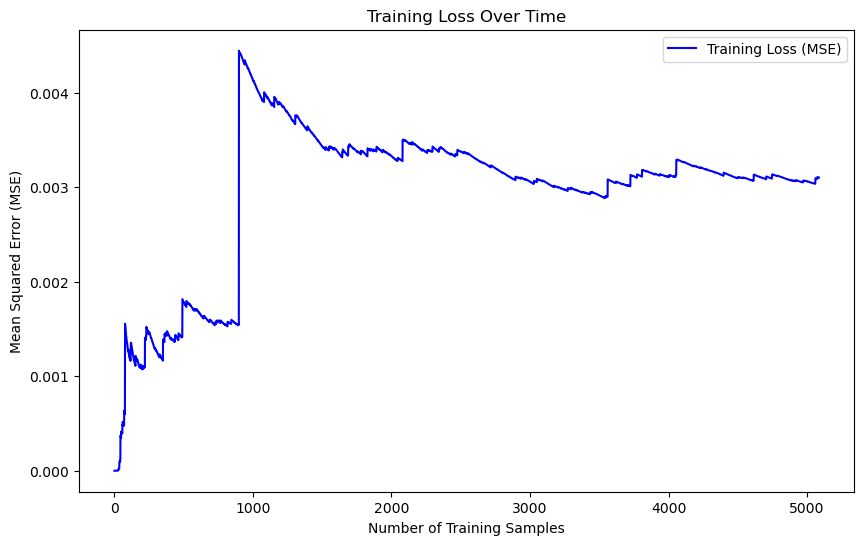

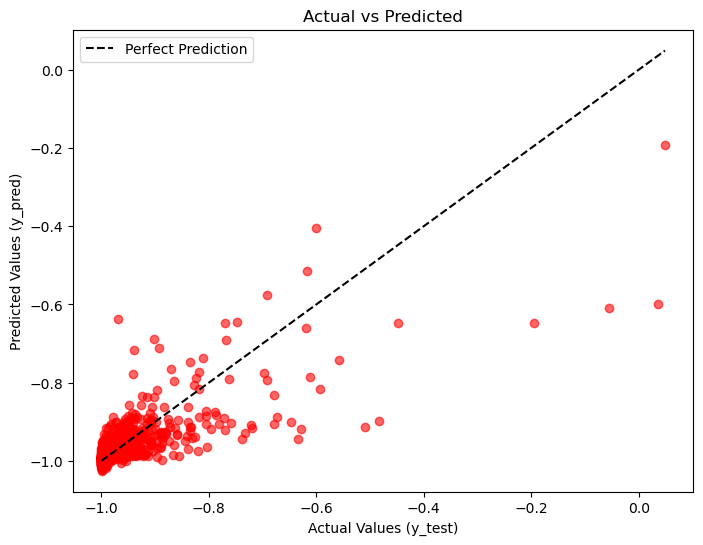

In [344]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming significant_features is the list of features with p-value < 0.05
X_significant = df_data_prep1[significant_features]  # Use only significant features
y = df_data_prep1[target_col]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# List to store the training loss (MSE)
training_loss = []

# Manually train the model and compute loss at each step for visualization
for i in range(1, len(X_train) + 1):
    # Fit the model on a subset of the data
    lr_model.fit(X_train[:i], y_train[:i])
    
    # Predict on the training data
    y_train_pred = lr_model.predict(X_train[:i])
    
    # Calculate MSE for the current subset and store it
    mse_train = mean_squared_error(y_train[:i], y_train_pred)
    training_loss.append(mse_train)

# Predict on the test set
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Mean Squared Error: {mse_train:.4f}")
print(f"Test Mean Squared Error: {mse_test:.4f}")
print(f"Training R-squared: {r2_train:.4f}")
print(f"Test R-squared: {r2_test:.4f}")

# Plot 1: Loss over training (MSE over training iterations)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, color='b', label='Training Loss (MSE)')
plt.title("Training Loss Over Time")
plt.xlabel("Number of Training Samples")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

# Plot 2: Actual vs Predicted (y_pred vs y_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='r', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--', label='Perfect Prediction')
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.legend()
plt.show()
